In [1]:
"""
June 26, 2020

Looking at starting position of walkers.
"""


import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
data = ares.analysis.GalaxyPopulation() #for lit values

In [3]:
# Independent variables
# redshifts = np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75])
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

Ms = np.linspace(7, 12, 60)

# print(Ms)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('logbins', Ms)]
blob_f1 = ['StellarMassFunction']

In [4]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [5]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)

# print(base_pars)
# This is important!
# base_pars['pop_calib_lum'] = None

In [15]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]',
]

is_log = [False, False, False, False, False, False, False, True]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(0, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')


In [16]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


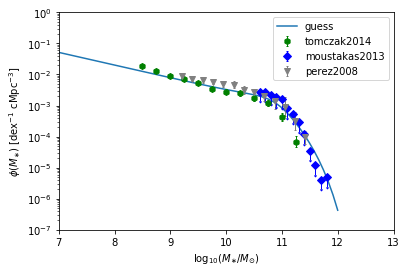

In [17]:
# base_pars
# Ms = np.logspace(7, 12, 60)

base_pars.update(guesses)
pop = ares.populations.GalaxyPopulation(**base_pars)

z = 1

smf = pop.StellarMassFunction(z, Ms)
pl.semilogy(Ms, smf, label='guess')
data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.legend()
pl.show()

In [18]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

# print(fitter_smf.data)

In [19]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [20]:
# print(fitter.blob_names)
# print(fitter.blob_ivars)
# print(fitter.blob_funcs, fitter.blob_kwargs)


In [21]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 30

fitter.jitter = [0.1] * len(fitter.parameters)
# fitter.jitter = [0.01, 0.01, 0.001, 0.005, 0.01, 0.01, 0.08, 0.01]
# fitter.jitter = [0.1, 0.1, 0.01, 0.05, 0.1, 0.1, 0.8, 0.1]

fitter.guesses = guesses
# fitter.debug('True')
# fitter.pops
# nwalkers

# Fixing position of walker 0 (parameter pq_func_par0[1])
# Moved from -0.30861069765589283 to 0.05905827539511975
# Fixing position of walker 1 (parameter pq_func_par0[1])
# Moved from -0.046805205660946037 to 0.05130051867478576
# Fixing position of walker 3 (parameter pq_func_par0[1])
# Moved from -0.005999280372492737 to 0.07804501587883185
# Fixing position of walker 4 (parameter pq_func_par0[1])
# Moved from -0.05209954884620366 to 0.019987830445783582
# Fixing position of walker 14 (parameter pq_func_par0[1])
# Moved from -0.06650239148881454 to 0.138576693735396
# Fixing position of walker 15 (parameter pq_func_par0[1])
# Moved from -0.012663131580304177 to 0.05155765004083664
# Fixing position of walker 16 (parameter pq_func_par0[1])
# Moved from -0.005026448884677796 to 0.138576693735396
# Fixing position of walker 17 (parameter pq_func_par0[1])
# Moved from -0.07855207041764783 to 0.138576693735396
# Fixing position of walker 20 (parameter pq_func_par0[1])
# Moved from -0.00

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best

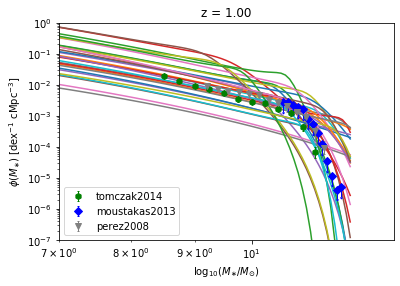

In [22]:
z = 1
# 2.5, 3.5

for w in fitter.guesses[:]:
#     print(w)
    
    pars_ch = {}
    for i in range(len(w)):
        pars_ch[free_pars[i]] = w[i]
        
    base_pars.update(pars_ch)
    pop = ares.populations.GalaxyPopulation(**base_pars)

    smf = pop.StellarMassFunction(z, Ms)
    pl.loglog(Ms, smf)#, label='guess')

data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.title("z = %.2f" %z)
pl.legend()
pl.show()
    

In [15]:
fitter.run('MCMC_files/test_smfcal_5', burn=5, steps=40, save_freq=4, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Tue Jun 30 15:43:06 2020
# Wrote MCMC_files/test_smfcal_5.burn.dd0000.facc.pkl: Tue Jun 30 15:56:11 2020
Writing data one last time because save_freq > steps.
# Wrote MCMC_files/test_smfcal_5.burn.dd0001.facc.pkl: Tue Jun 30 15:58:38 2020
# Burn-in complete in 931 seconds.
# Fixing position of walker 4 (parameter pq_func_par0[1])
# Moved from -0.018554054184946794 to 0.10147883243275771
# Fixing position of walker 12 (parameter pq_func_par0[1])
# Moved from -0.026726604033736237 to 0.061760079095139114
# Fixing position of walker 3 (parameter pq_func_par2[3])
# Moved from 0.1482926594689266 to 0.05282792790015336
# Fixing position of walker 6 (parameter pq_func_par2[3])
# Moved from 0.1292351782598517 to 0.0337856518421112
# Fixing position of walker 19 (parameter pq_func_par2[3])
# Moved from 0.12748836594930468 to 0.07318067025065922
# Fixing position of walker 22 (parameter pq_func_par2[3])
# Moved from 0.125904880819

In [11]:
anl = ares.analysis.ModelSet('MCMC_files/smf_run3_07_06')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run2')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run5')


labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels

# anl.skip = 5000


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : MCMC_files/                                                                            ####
#### prefix      : smf_run3_07_06                                                                         ####
#### N-d         : 8                                                                                      ####


# Loading MCMC_files/smf_run3_07_06.dd*.chain.pkl...
# Loaded MCMC_files/smf_run3_07_06.dd*.chain.pkl in 0.36 s.
# Loaded MCMC_files\smf_run3_07_06.dd0000.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0001.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0002.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0003.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0004.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0005.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0006.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0007.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0008.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0009.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0010.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0011.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0012.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run3_07_06.dd0013.

C:\Users\Emma\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


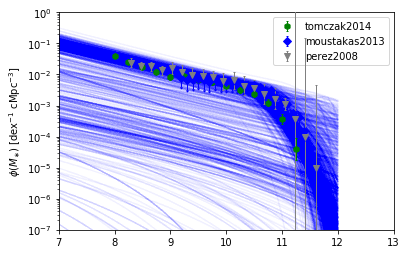

In [12]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.35
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [13]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 1.053481e+00
pq_func_par2[0]: 1.267846e-01
pq_func_par0[1]: 1.715381e-01
pq_func_par2[1]: -4.905101e-01
pq_func_par0[2]: 5.837792e-01
pq_func_par2[2]: -6.756674e-01
pq_func_par0[3]: 1.163050e+01
pq_func_par2[3]: 3.013367e-01


0 of 8800 chain elements ignored because of chain links with inf's/nan's.


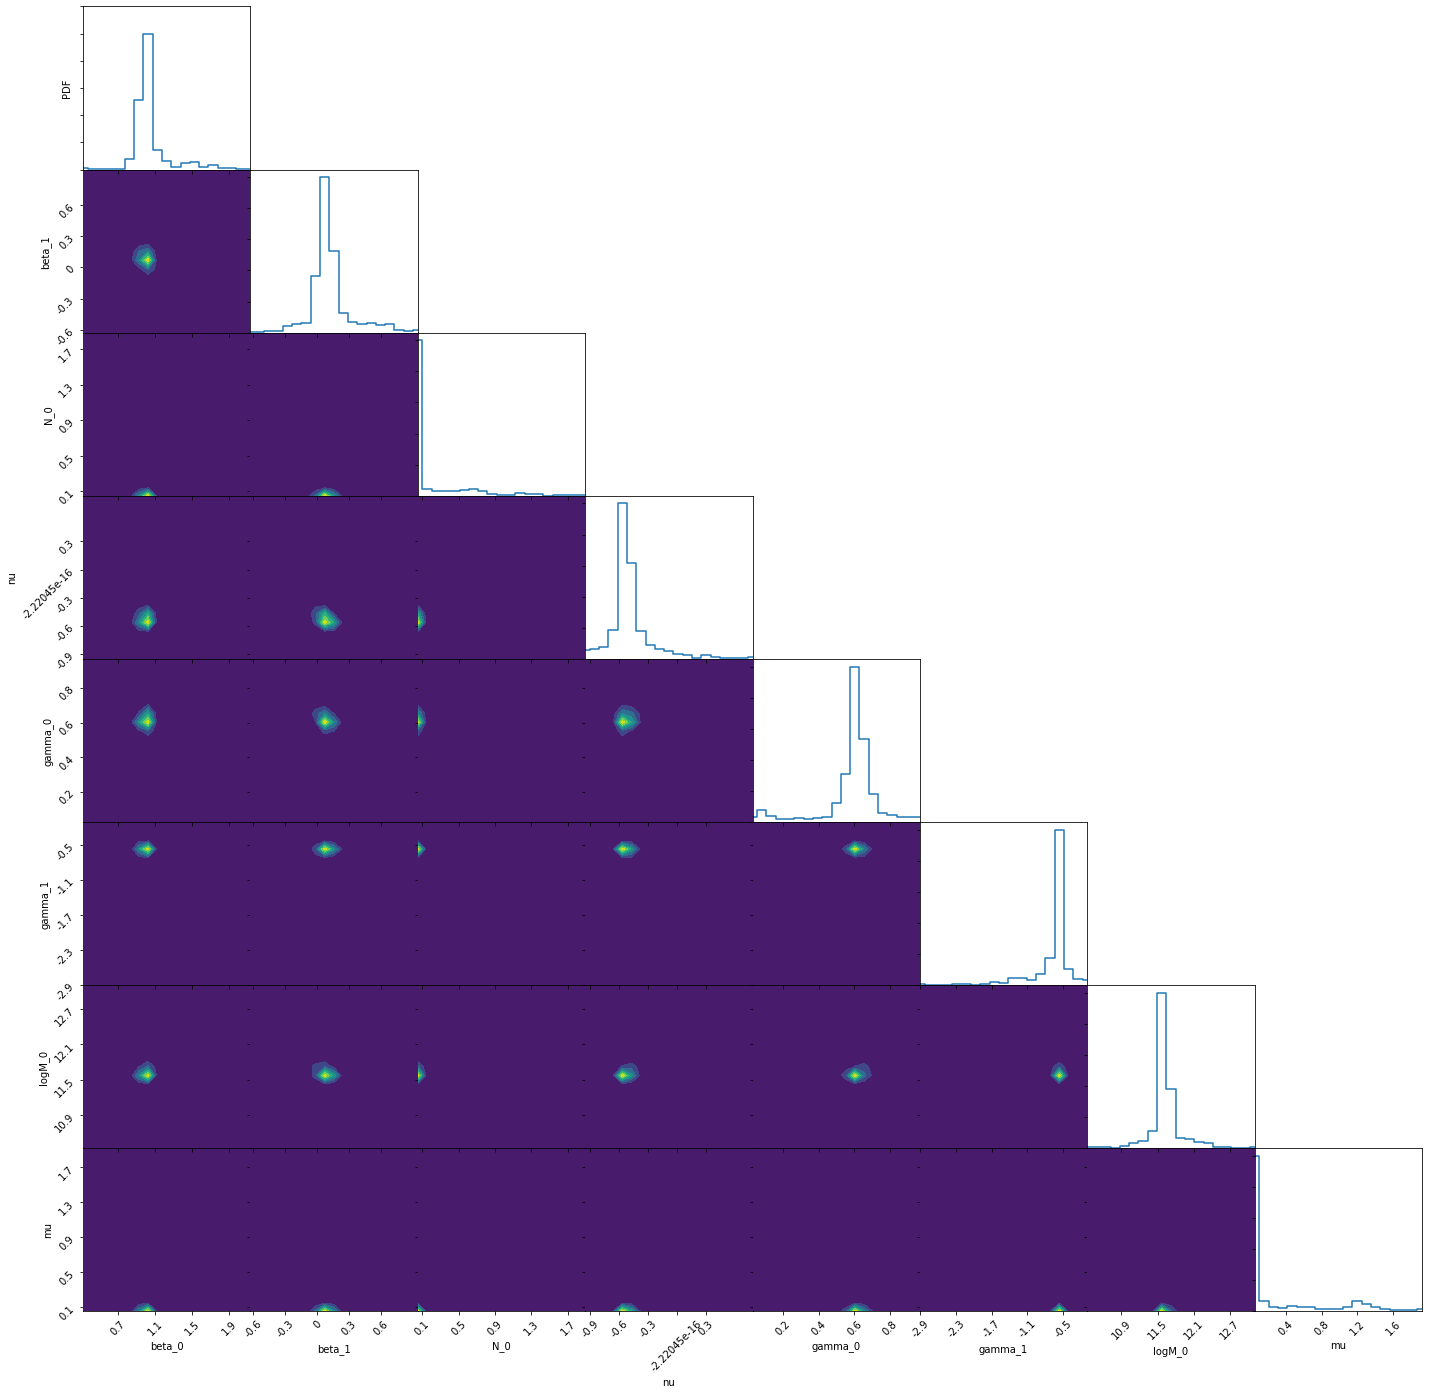

In [36]:

trig = anl.TrianglePlot(pars=params)

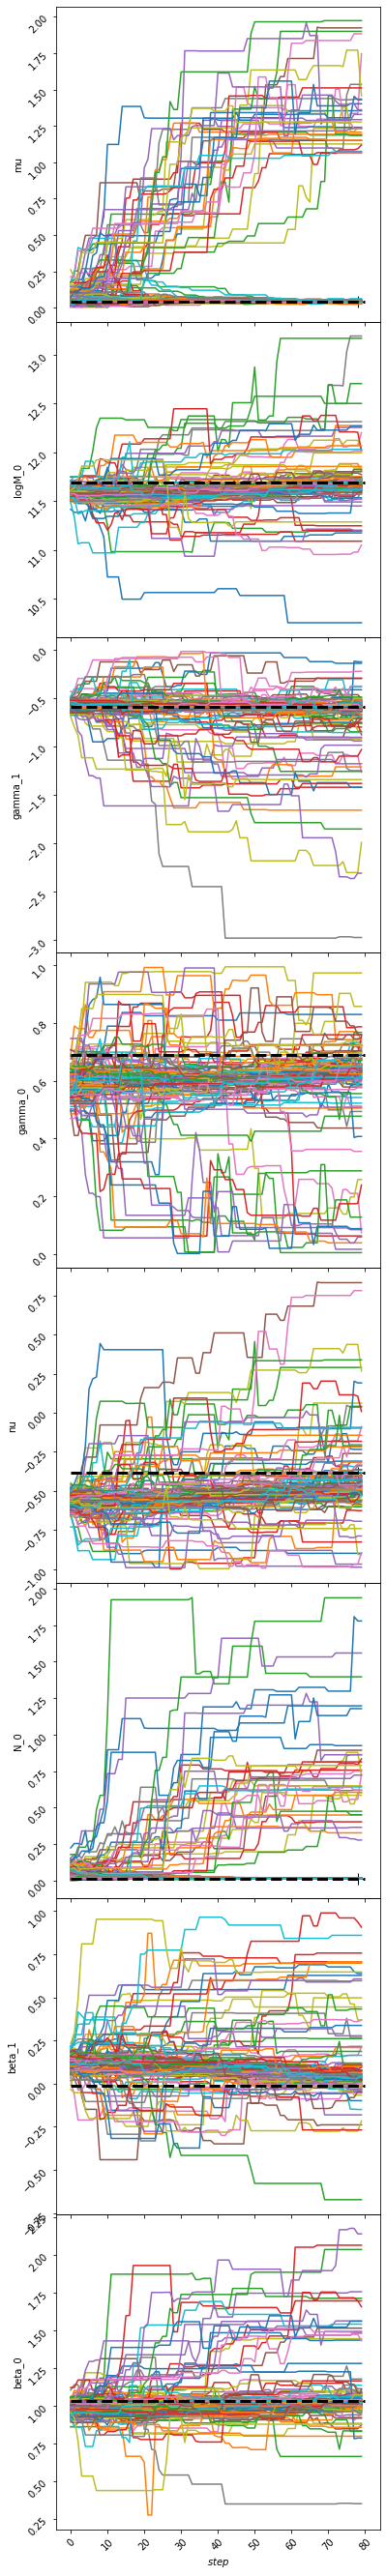

In [14]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [9]:
anl.max_likelihood_parameters()

{'pq_func_par0[0]': 1.0316316655135624,
 'pq_func_par2[0]': -0.011116834361449609,
 'pq_func_par0[1]': 0.014938823054626557,
 'pq_func_par2[1]': -0.38248881186760575,
 'pq_func_par0[2]': 0.6876873423724783,
 'pq_func_par2[2]': -0.5899198279363933,
 'pq_func_par0[3]': 11.685774731652085,
 'pq_func_par2[3]': 0.043090111791790175}

In [10]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.053481e+00
pq_func_par2[0]: 1.267846e-01
pq_func_par0[1]: 1.715381e-01
pq_func_par2[1]: -4.905101e-01
pq_func_par0[2]: 5.837792e-01
pq_func_par2[2]: -6.756674e-01
pq_func_par0[3]: 1.163050e+01
pq_func_par2[3]: 3.013367e-01


In [11]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [12]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(1.0316316655135624, array([0.09592047, 0.09116911]))
(-0.011116834361449609, array([ 0.23699579, -0.0166144 ]))
(0.014938823054626557, array([3.96434078e-01, 3.29619197e-04]))
(-0.38248881186760575, array([-0.00795389,  0.22808903]))
(0.6876873423724783, array([-0.01526268,  0.15951438]))
(-0.5899198279363933, array([0.06354989, 0.2015957 ]))
(11.685774731652085, array([0.04388217, 0.16315757]))
(0.043090111791790175, array([0.84887348, 0.00500614]))


In [13]:
pars_best = ares.util.ParameterBundle("emma:model1")

print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

{'pq_func_par0[0]': 1.0316316655135624, 'pq_func_par2[0]': -0.011116834361449609, 'pq_func_par0[1]': 0.014938823054626557, 'pq_func_par2[1]': -0.38248881186760575, 'pq_func_par0[2]': 0.6876873423724783, 'pq_func_par2[2]': -0.5899198279363933, 'pq_func_par0[3]': 11.685774731652085, 'pq_func_par2[3]': 0.043090111791790175}


[7.83114418e-02 7.34481580e-02 6.88898408e-02 6.46171900e-02
 6.06122099e-02 5.68580606e-02 5.33388862e-02 5.00398871e-02
 4.69472612e-02 4.40480473e-02 4.13300676e-02 3.87819704e-02
 3.63931606e-02 3.41536572e-02 3.20541175e-02 3.00858309e-02
 2.82406467e-02 2.65108863e-02 2.48893802e-02 2.33694408e-02
 2.19447975e-02 2.06095516e-02 1.93581968e-02 1.81855957e-02
 1.70869296e-02 1.60576707e-02 1.50935934e-02 1.41907535e-02
 1.33454565e-02 1.25542329e-02 1.18138449e-02 1.11212722e-02
 1.04736943e-02 9.86846295e-03 9.30310823e-03 8.77532685e-03
 8.28297086e-03 7.82403335e-03 7.39663453e-03 6.99901213e-03
 6.62951042e-03 6.28655873e-03 5.96864502e-03 5.67427945e-03
 5.40193939e-03 5.14998545e-03 4.91653128e-03 4.69923933e-03
 4.49500795e-03 4.29950231e-03 4.10646807e-03 3.90692711e-03
 3.68848472e-03 3.43569180e-03 3.13308240e-03 2.77240149e-03
 2.36192003e-03 1.92969412e-03 1.51392971e-03 1.14659085e-03
 8.43659275e-04 6.06226582e-04 4.26704814e-04 2.94447970e-04
 1.98981025e-04 1.313260

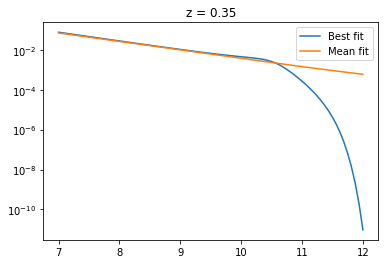

In [16]:
z = 0.35

Ms_short = np.linspace(7, 12, 80)
# Ms_short = [1e9]

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)

print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms_short)

obslf = ares.analysis.GalaxyPopulation()
# obslf.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.semilogy(Ms_short, ls_best, label='Best fit')

pl.semilogy(Ms_short, ls_mean, label='Mean fit')

pl.title("z = %.2f" %z)
pl.legend()
# pl.ylim(1e-15, 1e2)
pl.show()

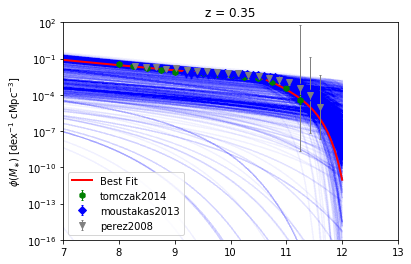

In [17]:
z = .35

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)
ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# print(ls_best)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, ax=ax, round_z=0.2, log10Mass=True)

ax.semilogy(Ms_short, ls_best, label='Best Fit', color="red", linewidth=2)

pl.title("z = %.2f" %z)
pl.legend()
pl.ylim(1e-16, 1e2)
pl.show()


In [45]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.ticker import LinearLocator, FormatStrFormatter

(50, 80)


C:\Users\Emma\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


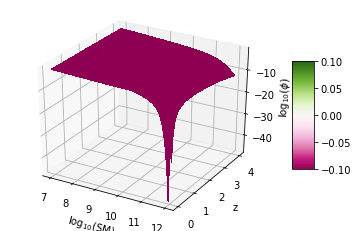

In [52]:
fig = pl.figure()
ax = fig.gca(projection='3d')

zArr = np.linspace(.01, 4, 50)

M, Z = np.meshgrid(Ms_short, zArr)

ls_best_grid = np.array([pop_best.StellarMassFunction(z, Ms_short) for z in zArr])

print(ls_best_grid.shape)

surf = ax.plot_surface(M, Z, np.log10(ls_best_grid), cmap=pl.cm.PiYG, linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.zaxis.set_scale('log')

ax.set_xlabel('log$_{10}$(SM)')
ax.set_ylabel('z')
ax.set_zlabel('log$_{10}(\phi)$');

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

pl.show()